### PA3: Structrue from Motion
#### In this assignment, you will be implementing Tomasi-Kanade	Factorization algorithm	for Rigid Structure from Motion (see Lecture 23).

### Task 1
#### Since we do not want to introduce the complexity of extracting feature points from images and tracking them over multiple frames, here we will generate W matrix using syntheic data i.e. by projecting a 3D model on 2D image plane.

#### Load the data file and generate a 2D image dataset	by generating an orthographic camera with optical axis paralle to the XY plane, which rotates around the teapot	in 10° increments and always looks towards the center of the object

#### Note: Code for loading the point cloud and visualizing it has been given to you. Further build on it and take images of the teapot and visualize them

In [35]:
from scipy.io import loadmat
x = loadmat('teapot.mat')

In [36]:
a = []
b = []
c = []
for points in x['verts']:
    a.append(points[0])
    b.append(points[1])
    c.append(points[2])

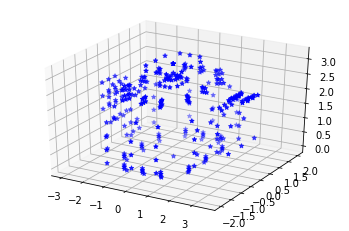

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,c, c='b', marker='*')

In [38]:
### Your implementation comes here
import numpy as np
import math
intrinsic = np.array([[1, 0, 0],[0, 1, 0]])

def rotation_matrix_y(angle):
    rot_angle=math.radians(angle)
    R = np.array([[math.cos(rot_angle),0,math.sin(rot_angle)],[0,1,0],[-math.sin(rot_angle),0,math.cos(rot_angle)]])
    return R      

In [39]:
### Your implementation comes here
### Hint: new2Dpts = K[R|T]*3DPoints
### Useful functions: np.dot, np.vstack
F = 3
points_3d = np.vstack((a,b,c))
image_3d_frames = []
image_3d_frames.append(points_3d)
rot_matrix = rotation_matrix_y(10)


for i in range(F-1):
    image_3d_rotated = np.dot(rot_matrix,image_3d_frames[i])
    image_3d_frames.append(image_3d_rotated)


image_3d_frames = np.asarray(image_3d_frames)
image_3d_frames.shape

(3, 3, 306)

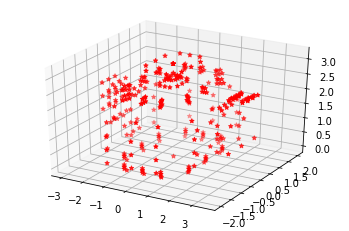

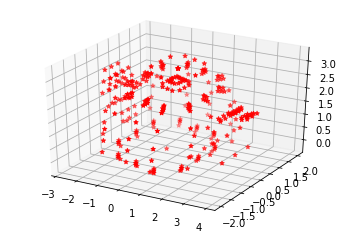

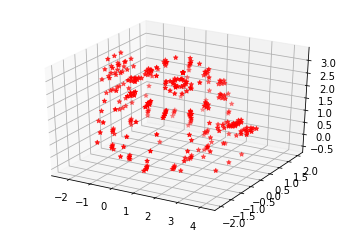

In [40]:
#plot

for i in range(image_3d_frames.shape[0]):
    x = image_3d_frames[i,0,:]
    y = image_3d_frames[i,1,:]
    z = image_3d_frames[i,2,:]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z, c='r', marker='*')

### Task 2
#### Use the data generated in previous task to generate a W matrix, and use that as input in Tomasi Kanade Factorization method to compute the 3D structure

In [41]:
### Your implementation for Tomasi Kanade Factorization method comes here
### Useful functions: np.dot, np.linalg.svd, np.linalg.pinv, np.linalg.cholesky
W_matrix = np.zeros((2*F,points_3d.shape[1]))

init_angle = 0
for i in range(F):
    rot_mat = rotation_matrix_y(init_angle)
    # Getting our Camera Matrix
    cam_mat = np.dot(intrinsic,rot_mat)
    temp_2d = np.dot(cam_mat,points_3d)

    W_matrix[i*2:i*2+2,:] = temp_2d
    init_angle +=10

In [42]:
U, S, V = np.linalg.svd(W_matrix)
U = U[:,:3]
V = V[0:3,:]
S = S[0:3]
S = np.diag(S)

In [43]:
R_hat = U
S_hat = np.dot(S,V)

In [44]:
rows = R_hat.shape[0] + int(0.5*R_hat.shape[0])
cols = 6

A_matrix = np.zeros((rows,cols))

In [45]:
A_matrix.shape

(9, 6)

In [49]:
# Constructing the A_Matrix
T_Matrix = []
for i in range(0,R_hat.shape[0],2):
    row_1 = R_hat[i]
    row_2 = R_hat[i+1]


    for j in range(3):
        T_1_Matrix = []

        if j == 0:
            for m in range(len(row_1)):
                for n in range(m,len(row_1)):
                    val = row_1[m]*row_1[n]
                    if m != n:
                        val*=2
                    T_1_Matrix.append(val)  
            T_Matrix.append(T_1_Matrix)

        if j == 1:
            for m in range(len(row_2)):
                for n in range(m,len(row_1)):
                    val = row_2[m]*row_1[n]
                    if m != n:
                        val+= row_1[m] *row_2[n]
                    T_1_Matrix.append(val) 
            T_Matrix.append(T_1_Matrix)

        if j == 2:
            for m in range(len(row_2)):
                for n in range(m,len(row_2)):
                    val = row_2[m]*row_2[n]
                    if m != n:
                        val*=2
                    T_1_Matrix.append(val)  
            T_Matrix.append(T_1_Matrix)

In [50]:
eqn = [1,0,1]
ans_col = []
for i in range(F):
    ans_col.append(eqn)

ans_col = np.asarray(ans_col).reshape(F*3,1)

In [51]:
T_Matrix = np.asarray(T_Matrix)
T_Matrix

array([[ 3.13888670e-01, -1.34252892e-05,  8.04921273e-01,
         1.43552800e-10, -1.72135886e-05,  5.16025520e-01],
       [-7.95694921e-06, -3.23464923e-01, -9.39147180e-06,
         6.91743690e-06, -4.14739083e-01,  1.03951232e-06],
       [ 2.01705404e-10,  1.63994066e-05, -4.11038793e-11,
         3.33333333e-01, -1.67094986e-06,  2.09405508e-12],
       [ 3.40038060e-01, -1.66954853e-05,  1.34781629e-02,
         2.04932375e-10, -3.30881299e-07,  1.33559222e-04],
       [-8.28175792e-06, -3.36669006e-01,  6.79702620e-07,
         8.26503427e-06, -6.67231151e-03,  1.67236469e-08],
       [ 2.01705404e-10,  1.63994066e-05, -4.11038793e-11,
         3.33333333e-01, -1.67094986e-06,  2.09405507e-12],
       [ 3.46073270e-01, -1.90774455e-05, -8.18399436e-01,
         2.62913202e-10,  2.25573195e-05,  4.83840920e-01],
       [-8.35492960e-06, -3.39643572e-01,  1.07302246e-05,
         9.36150276e-06,  4.01597195e-01, -1.00657316e-06],
       [ 2.01705404e-10,  1.63994066e-05, -4.110

In [52]:
x = np.linalg.pinv(T_Matrix)
Q = np.dot(x,ans_col)
Q_new = np.asarray([ [Q[0],Q[1],Q[2]], [Q[1] ,Q[3],Q[4]],[Q[2],Q[4],Q[5]] ])
Q_new = Q_new.reshape(3,3)
Q_new

array([[ 2.93856211e+00,  1.65429147e-06,  5.70430056e-02],
       [ 1.65429147e-06,  3.00000000e+00, -8.76849208e-06],
       [ 5.70430056e-02, -8.76849208e-06,  6.14378923e-02]])

In [54]:
# Computing R AND S
Q1 = np.linalg.cholesky(Q_new)
Q1_inv = np.linalg.inv(Q1)
R = np.dot(R_hat,Q1)
S = np.dot(Q1_inv,S_hat)

In [55]:
a1 = S[0,:]
b1 = S[1,:]
c1 = S[2,:]

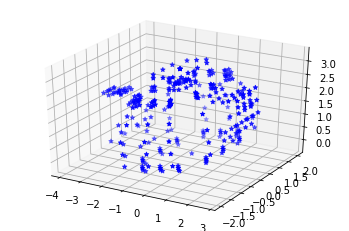

In [56]:
## Plot the reconstructed mode

# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the reconstructed 3D points are 
# in variables a1, b1 and c1 respectively, the reconstructed model can be plotted as:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a1,b1,c1, c='b', marker='*')

In [57]:
## Evaluate your reconstruction
# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the 3D points that you have reconstructed are 
# in variables a1, b1 and c1 respectively, the error in reconstruction can be calcualted as:

err = 0.0
j = 0
for i in range(len(a1)):
  err = err + math.sqrt( ((a1[i]-a[i])*(a1[i]-a[i])) + ((b1[i]-b[i])*(b1[i]-b[i])) + ((c1[i]-c[i])*(c1[i]-c[i])) )
  j=j+1
  
print ("Mean Euclidean Error : ",(err/j))

Mean Euclidean Error :  2.7943902315745976
